In [1]:
import mrcfile
import file
from pathlib import Path
import glob
import numpy as np
import image_process
import matplotlib.pyplot as plt
import cv2
from datacube import DataCube
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

In [2]:
elem1, elem2, elem3, elem4, elem5 = [14,8,0,0,0]
elems = np.array([elem1, elem2, elem3, elem4, elem5])
e1, e2, e3, e4, e5 = [1,2,0,0,0]
es = np.array([e1,e2,e3,e4,e5])
e_tot = np.sum(np.array(es))
e_ratio = es/e_tot

In [3]:
paramK = np.loadtxt("./assets/Parameter_files/Kirkland_2010.txt")
azavg = np.loadtxt("./assets/Parameter_files/Amorphous_SiO2_azav_0.00167.txt")

In [4]:
element_nums = [14,8,1,1,1] # si(14) , o(8), else is 1
paramK_elems = paramK[element_nums,:]
paramK_elems[0]

array([1.06543892e+00, 1.04118455e+00, 1.20143691e-01, 6.87113368e+01,
       1.80915263e-01, 8.87533926e-02, 1.12065620e+00, 3.70062619e+00,
       3.05452816e-02, 2.14097897e-01, 1.59963502e+00, 9.99096638e+00])

In [5]:
ds = 0.00167 # ds = Calibration factor
start_num = 133
end_num = 2500
x = np.arange(start_num,end_num+1) # selected x ranges, end point = end point(eRDF) + 1
Iq = azavg[start_num-1:end_num]
q = x*ds*2*np.pi
s = q/2/np.pi
s2 = s**2

L = np.uint16(len(q))

In [6]:
def KirklandFactors(s2, paramK_element):
    a1,b1,a2,b2,a3,b3,c1,d1,c2,d2,c3,d3 = paramK_element
    f = (a1/(s2+b1))+(a2/(s2+b2))+(a3/(s2+b3))+(np.exp(-s2*d1)*c1)+(np.exp(-s2*d2)*c2)+(np.exp(-s2*d3)*c3)
    return np.array(f)
f = np.array([KirklandFactors(s2, paramK_elem) for paramK_elem in paramK_elems])

In [7]:
fq = np.sum( f * e_ratio[:,None], axis=0) # fq.shape = 2366,
fq_sq = fq**2
gq = np.sum( f**2 * e_ratio[:,None], axis=0)

In [8]:
# Auto Fit atomic scattering curve = N*gq+C
fullQRange = True
if fullQRange:
    AFrange=0
else:
    AFrangenge = 2/3*L
wi = np.ones((L,1))
wi[0:AFrange] = 0
qmax,qpos = q.max(),q.argmax() # qmax = q_fix
fqfit = gq[qpos]
iqfit = Iq[qpos]

In [10]:
a1 = np.sum(wi*gq*Iq)
a2 = np.sum(wi*Iq*fqfit)
a3 = np.sum(wi*gq*iqfit)
a4 = np.sum(wi)*fqfit*iqfit
a5 = np.sum(wi*gq**2)
a6 = 2*np.sum(wi*gq*fqfit)
a7 = np.sum(wi)*fqfit*fqfit

N = (a1-a2-a3+a4)/(a5-a6+a7)
C = iqfit-N*fqfit

Autofit = N*gq+C

SS = np.sum((Iq-Autofit)**2);

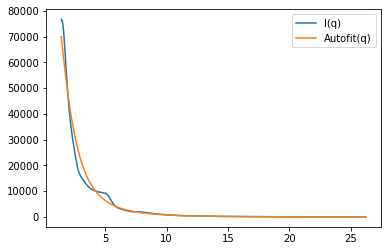

In [13]:
import matplotlib.pyplot as plt
plt.plot(q,Iq)
plt.plot(q,Autofit)
plt.legend(["I(q)","Autofit(q)"])

In [14]:
damping = 0.3
rmax = 10
dr = 0.01
r = np.arange(0.01,rmax+dr,dr) # rmax+dr to fit the eRDF

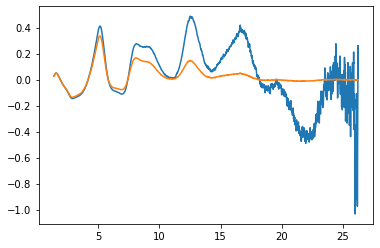

In [15]:
phiq = ((Iq - Autofit)*s)/(N*fq_sq);
phiq_damp = phiq*np.exp(-s2*damping)
plt.plot(q,phiq)
plt.plot(q,phiq_damp)

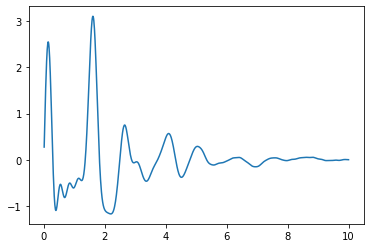

In [16]:
Gr = 8 * np.pi * phiq_damp @ np.sin(q[:,None]*r) * ds
plt.plot(r,Gr)